# Barotropic velocity

Barotropic velocities are determined from ADCP data, the ADCP measurement are aggregated and averaged over the period of the CTD cast. Then, the adcp velocities are averaged over a certain depth. The first figure shows the barotropic velocities determined from the upper 100 meter of the water column with in circles the associated standard deviation from the mean. The second figure shows the barotropic velocities determined from the mixed layer depth to the maximum depth the ADCP reached, again the standard deviation from the mean is shown in circles.

In [1]:
%run ../_setup.py

import math
import numpy as np
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

from netCDF4 import Dataset, num2date

from gsw import sigma0

from OceanPy.interpolation import OI

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook


In [3]:
# load adcp and ctd data
input_file_adcp = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_adcp.nc')
input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'netcdf', 'ss9802_ctd_gsw.nc')

adcp = Dataset(input_file_adcp)
ctd = Dataset(input_file_ctd)

# format times with timestamp
time_adcp = num2date(adcp['time'][:], adcp['time'].units)
time_ctd = num2date(ctd['time'][:], ctd['time'].units)

# calculate mean of the adcp velocities based on the time interval 
# that the ctd was overboard
nst, npl = ctd.dimensions['profile'].size, adcp.dimensions['plevel'].size
utmean, vtmean = np.ma.masked_all((nst, npl)), np.ma.masked_all((nst, npl))
ptmean = np.ma.masked_all((nst, npl))
lonmean, latmean = np.ma.masked_all((nst,)), np.ma.masked_all((nst,))
for ist, tctd in enumerate(time_ctd):
    it = [it for it, tadcp in enumerate(time_adcp) if tctd[0] <= tadcp < tctd[1]]
    if len(it):
        utmean[ist,] = np.ma.masked_invalid(np.nanmean(adcp['u'][it], axis=0))
        vtmean[ist,] = np.ma.masked_invalid(np.nanmean(adcp['v'][it], axis=0))
        ptmean[ist,] = np.ma.masked_invalid(np.nanmean(adcp['p'][it], axis=0))
        lonmean[ist,] = np.nanmean(adcp['lon'][it])
        latmean[ist,] = np.nanmean(adcp['lat'][it])
            
# find index of pressure closest to predefined pressure level
plevel = 100
pressure = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), 
                       adcp.dimensions['plevel'].size)
ip = (np.abs(pressure-plevel)).argmin()

# calculate mean of velocities from surface to pressure level
utdmean = np.nanmean(utmean[:, slice(0, ip)], axis=1)
vtdmean = np.nanmean(vtmean[:, slice(0, ip)], axis=1)

# calculate magnitude of vectors and calculate standard deviation
vmag = np.sqrt(utmean[:, slice(0, ip)]**2 + vtmean[:, slice(0, ip)]**2)
vmagstd = np.nanstd(vmag, axis=1)



In [4]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p']):
    pressure_levels[p] = ip

# define reference and interest level 
p_ref = 1500
p_int = 1000

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# find finite values
idx = np.isfinite(D[2:])

# # interpolate (using Optimal Interpolation) dynamic height contours on grid
# lon, lat = ctd['lon'][2:, 0][idx], ctd['lat'][2:, 0][idx]
# xx, yy, dhb, dha = OI(lon, lat, D[2:][idx], L=(lon.max() - lon.min())/5)

# interpolate linearly dynamic height contours on grid
lon, lat = ctd['lon'][2:, 0][idx], ctd['lat'][2:, 0][idx]
nx, ny = 20, 20
xi = np.linspace(lon.min(), lon.max(), nx)
yi = np.linspace(lat.min(), lat.max(), ny)
xx, yy = np.meshgrid(xi, yi)
Dgrd = griddata((lon, lat), D[2:][idx], (xx, yy), method='linear')



(-52.5, -48)

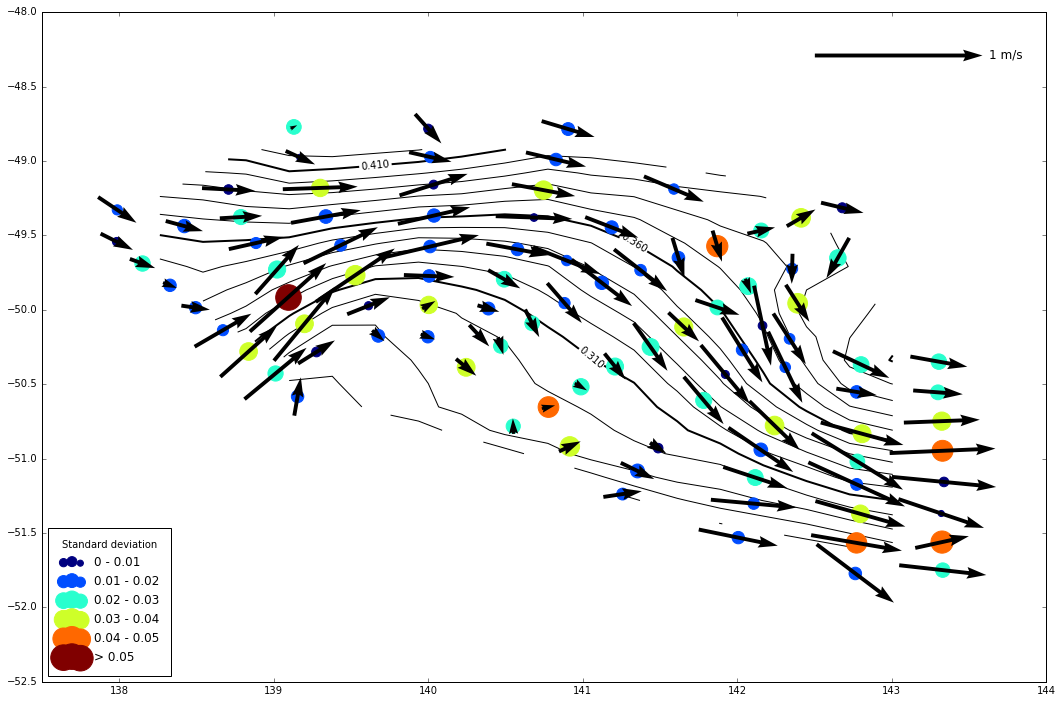

In [5]:
# PLOT

fig, ax = plt.subplots(figsize=(18, 12))

# plot dynamic height contours
step = 0.01
xmin, xmax = math.floor(np.nanmin(Dgrd)*100)/100, math.ceil(np.nanmax(Dgrd)*100)/100
nsteps = int((xmax - xmin) / step) + 2
bounds = np.linspace(xmin, xmax, nsteps)

ct = ax.contour(xx, yy, Dgrd, bounds, colors='k', zorder=-1)

for ib, b in enumerate(bounds):
    if b in bounds[4::5]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(ct, bounds[4::5], inline=1, fontsize=10)


# plot quiver plot
Q = ax.quiver(lonmean[2:], latmean[2:], utdmean[2:], vtdmean[2:], 
              pivot='mid', units='inches', width=0.003*18, zorder=2)
qk = plt.quiverkey(Q, 0.85, 0.85, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'large'})

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
colors = cm.jet(np.linspace(0, 1, len(std_bins)))
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (vmagstd[2:] > std_bins[i])
        label = '> %s' % (std_bins[i])
    else:
        criteria = (vmagstd[2:] > std_bins[i]) & (vmagstd[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(lonmean[2:][criteria], latmean[2:][criteria], s=vmagstd[2:][criteria]*1e4, 
               label=label, color=colors[i], zorder=1)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='large', loc=3)
legend.get_title().set_fontsize('x-large')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])


## Mixed layer depth

In [6]:
def mixed_layer_depth(z, sig0=False, pt=False, SA=False, CT=False, smooth=False):

    # The reference depth is to avoid large part of the
    # strong diurnal cycle in the top few meters of the ocean. Dong et al. 2008
    ref = 20
    iref, ref_dep = min(enumerate(z), key=lambda x: abs(abs(x[1]) - ref))

    # smooth profiles with moving average
    if sig0 is not False:
        if smooth:
            N = 5
            sig0 = np.concatenate([np.mean(sig0[:N - 1]) * np.ones(N - 1, ),
                                   np.convolve(sig0.data, np.ones((N,)) / N, mode='valid')])
            sig0 = np.ma.masked_where(sig0 > 1e36, sig0)

        # near-surface value
        sig0_s = sig0[iref]

    if pt is not False:
        if smooth:
            N = 5
            pt = np.concatenate([np.mean(pt[:N - 1]) * np.ones(N - 1, ),
                                 np.convolve(pt.data, np.ones((N,)) / N, mode='valid')])
            pt = np.ma.masked_where(pt > 1e36, pt)

        # near-surface values
        pt_s = pt[iref]

    # Mixed Layer Depth based on de Boyer Montegut et al. 2004's property difference based criteria
    # MLD in potential density difference, fixed threshold criterion (sig0_d - sig0_s) > 0.03 kg/m^3
    if sig0 is not False and SA is False and CT is False:
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if sig0[i] - sig0_s > 0.03), np.nan)

    # MLD in potential temperature difference, fixed threshold criterion abs(pt_d - pt_s) > 0.2Â°C
    if pt is not False:
        imld = iref + next((i for i in range(len(pt[iref:]))
                            if abs(pt[i] - pt_s) > 0.2), np.nan)

    # MLD in potential density and potential temperature difference
    if sig0 is not False and pt is not False:
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if 0.03 < abs(sig0[i] - sig0_s) < 0.125
                            and 0.2 < abs(pt[i] - pt_s) < 1),
                           next(i for i in range(len(sig0[iref:]))
                                if sig0[i] - sig0_s > 0.03))

    # MLD in potential density with a variable threshold criterion
    if sig0 is not False and SA is not False and CT is not False:
        SA_s = SA[iref]
        CT_s = CT[iref]
        dsig0 = sigma0(SA_s, CT_s - 0.2) - sigma0(SA_s, CT_s)
        imld = iref + next((i for i in range(len(sig0[iref:]))
                            if sig0[i] - sig0_s > dsig0), np.nan)

    return imld, sig0, pt

In [7]:
# plot mixed layer depth
smooth = True
imld = []
for ist in range(nst):
    
    # read variables
    sig0 = ctd['sigma0'][ist,]
    pt = ctd['pt'][ist,]
    z = ctd['z'][ist,]

    # determine index of mixed layer depth 
    imld_tdd = mixed_layer_depth(z, sig0=sig0, pt=pt, smooth=smooth)[0]
    imld.append(imld_tdd)
    
# construct adcp pressure levels
padcp = np.linspace(np.nanmin(adcp['p'][:]), np.nanmax(adcp['p'][:]), adcp.dimensions['plevel'].size)

# find deepest adcp measurements
ipmax = [np.where(ptmean[ist].mask==False)[0][-1] if not all(ptmean[ist].mask) else 0
         for ist in range(nst)]
# pmax = [padcp[i] if np.isfinite(i) else np.nan for i in ipmax]

# find pressure of mixed layer depth
pmld = [ctd['p'][i] for i in imld]
imldadcp = [(np.abs(padcp - p)).argmin() for p in pmld]
# pmldadcp = [padcp[i] for i in imldadcp]

# calculate mean of velocities from surface to pressure level
utdmean = np.array([np.nanmean(utmean[ist, slice(imldadcp[ist], ipmax[ist])]) for ist in range(nst)])
vtdmean = np.array([np.nanmean(vtmean[ist, slice(imldadcp[ist], ipmax[ist])]) for ist in range(nst)])

# calculate magnitude of vectors and calculate standard deviation
vmag = np.array([np.sqrt(utmean[ist, slice(imldadcp[ist], ipmax[ist])]**2 +
                         vtmean[ist, slice(imldadcp[ist], ipmax[ist])]**2) for ist in range(nst)])

vmagstd = np.array([np.nanstd(vmag[ist]) if len(vmag[ist]) !=0 else np.nan for ist in range(nst)])


((137.5, 144), (-52.5, -48))

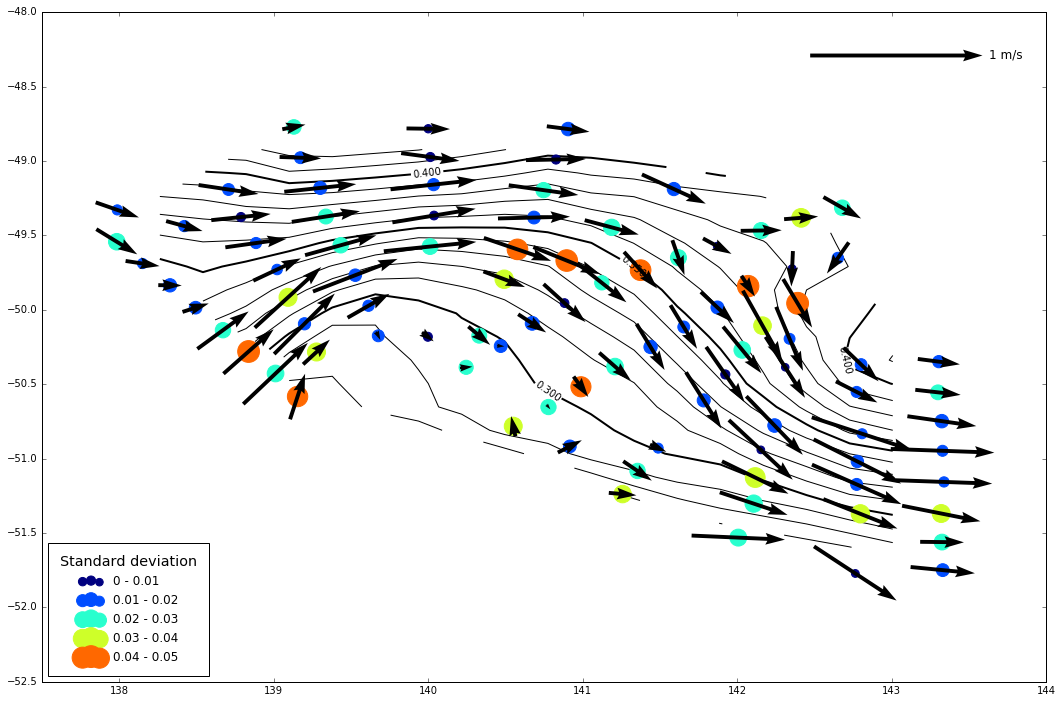

In [18]:
# PLOT

fig, ax = plt.subplots(figsize=(18, 12))

# plot dynamic height contours
ct = ax.contour(xx, yy, Dgrd, bounds, colors='k', zorder=-1)

for ib, b in enumerate(bounds):
    if b in bounds[4::5]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=2)
ax.clabel(ct, bounds[4::5], inline=1, fontsize=10)

# plot quiver plot
Q = ax.quiver(lonmean[2:], latmean[2:], utdmean[2:], vtdmean[2:], 
              pivot='mid', units='inches', width=0.003*18, zorder=2)
qk = plt.quiverkey(Q, 0.85, 0.85, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'large'})

# plot standard deviation scatter
for i in range(len(std_bins)-1):
    criteria = (vmagstd[2:] > std_bins[i]) & (vmagstd[2:] <= std_bins[i + 1])
    label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(lonmean[2:][criteria], latmean[2:][criteria], s=vmagstd[2:][criteria]*1e4, 
               label=label, color=colors[i], zorder=1)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='large', loc=3)
legend.get_title().set_fontsize('x-large')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])
